In [1]:
!nvidia-smi

Sat Apr 15 17:09:11 KST 2023

+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:14:00.0 Off |                    0 |
| N/A   32C    P0    24W / 250W |      4MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:15:00.0 Off |                    0 |
| N/A   32

In [2]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import nibabel as nib

from monai.apps import download_and_extract
from monai.config import print_config
from monai.utils import set_determinism

print_config()
set_determinism(0)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

MONAI version: 1.1.0
Numpy version: 1.23.5
Pytorch version: 1.7.1+cu110
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/aistore3/.conda/envs/snuimageseg/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 5.0.0
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.0
gdown version: 4.6.0
TorchVision version: 0.8.2+cu110
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.0
pandas version: 1.5.2
einops version: 0.6.0
transformers version: 4.25.1
mlflow version: 2.1.1
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [8]:
directory = "temp"
if not os.path.exists(directory):
    os.makedirs(directory)
root_dir = tempfile.mkdtemp() if directory is None else directory
data_dir = "HCC"

In [12]:
black_list = ['0085263']
all_patients = sorted(glob.glob(os.path.join(data_dir, "*.nii.gz")))
patients = [x for x in all_patients if os.path.basename(x).split('.')[0] not in black_list]

print(len(patients))

246


In [13]:
def nii_loader(filename) :
    nimg = nib.load(filename)
    return nimg.get_fdata() , nimg.affine, nimg.header

def visualize(dataset, idx=0, target_layer=10):
    import matplotlib.pyplot as plt    

    image = dataset[idx]
    image_data, image_affine, image_header = nii_loader(image)
    
    print('[file path]', image)
    print('[dimension]', image_data.shape)
    target_image = image_data[:,:,target_layer]

    plt.imshow(target_image, cmap='gray')
    plt.show()

[file path] HCC/0020491.nii.gz
[dimension] (320, 320, 100)


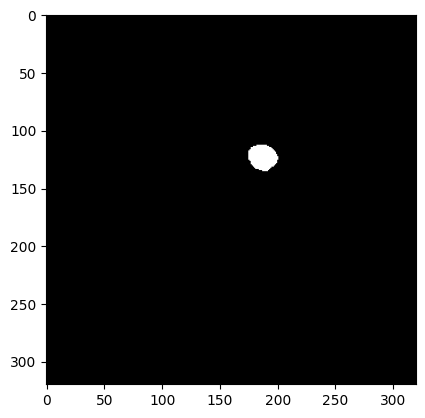

In [17]:
visualize(patients, idx=1,  target_layer=80)

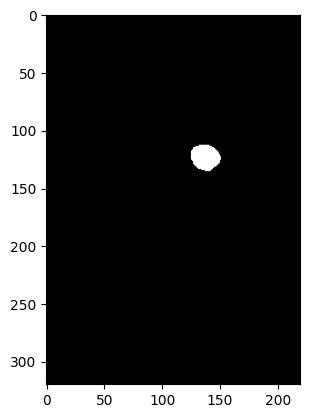

112 184 124 69 74 12


In [26]:
sample3d = nii_loader(patients[1])[0][:,50:-50,:]
plt.imshow(sample3d[:,:,80], cmap='gray')
plt.show()

front = end = left = right = top = bottom = 0
    
for i in range(sample3d.shape[0]):
    if np.sum(sample3d[i,:,:]) > 0: break
    front += 1
for i in range(1, sample3d.shape[0] + 1):
    if np.sum(sample3d[-i,:,:]) > 0: break
    end += 1
for j in range(sample3d.shape[1]):
    if np.sum(sample3d[:,j,:]) > 0: break
    left += 1
for j in range(1, sample3d.shape[1] + 1):
    if np.sum(sample3d[:,-j,:]) > 0: break
    right += 1    
for k in range(sample3d.shape[2]):
    if np.sum(sample3d[:,:,k]) > 0: break
    top += 1
for k in range(1, sample3d.shape[2] + 1):
    if np.sum(sample3d[:,:,-k]) > 0: break
    bottom += 1
print(front, end, left, right, top, bottom)

In [29]:
def ensure_fit_center(filename):
    image = nii_loader(filename)[0]
    front = end = left = right = top = bottom = 0
    
    for i in range(image.shape[0]):
        if np.sum(image[i,:,:]) > 0:
            break
        front += 1
    for i in range(1, image.shape[0] + 1):
        if np.sum(image[-i,:,:]) > 0:
            break
        end += 1
    for j in range(image.shape[1]):
        if np.sum(image[:,j,:]) > 0:
            break
        left += 1
    for j in range(1, image.shape[1] + 1):
        if np.sum(image[:,-j,:]) > 0:
            break
        right += 1    
    for k in range(image.shape[2]):
        if np.sum(image[:,:,k]) > 0:
            break
        top += 1
    for k in range(1, image.shape[2] + 1):
        if np.sum(image[:,:,-k]) > 0:
            break
        bottom += 1
    
    v_center = (front + (image.shape[0] - end))/2
    h_center = (left + (image.shape[1] - right))/2
    l_center = (top + (image.shape[2] - bottom))/2
    
    return front, end, left, right, top, bottom, v_center, h_center, l_center

In [ ]:
%%time

results = []
for patient in patients:
    results.append([os.path.basename(patient).split('.')[0]] + list(ensure_fit_center(patient)))
df = pd.DataFrame(results, columns=["patID", "front", "end", "left", "right", "top", "bottom",
                                    "v_center", "h_center", "l_center"]).set_index("patID")
print(df)
df.to_excel("nifti_center.xlsx")

         front  end  left  right  top  bottom  v_center  h_center  l_center
patID                                                                      
0007739    102  199   185    117   45      45     111.5     194.0      50.0
0020491    112  184   174    119   74      12     124.0     187.5      81.0
0050368     80  227   180    127   71      22      86.5     186.5      74.5
0059047    151  342   271    225   63      15     160.5     279.0      66.0
0063193    116  191   170    137   70      23     122.5     176.5      73.5
...        ...  ...   ...    ...  ...     ...       ...       ...       ...
0100139     85  213   140    157   48      40      96.0     151.5      54.0
0100140     77  255   137    116   50      30     103.0     160.5      62.0
0100157     64  221   172    115   66      15      81.5     188.5      75.5
0100158    182  176    78    197   73      20     195.0      90.5      78.5
0100164    108  186   219     77   43      43     121.0     231.0      50.0

[246 rows x